source:https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset/data

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rezajsh","key":"0c18fd25e0aecbc3fa70759b7cff0840"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
ls -a

./  ../  .config/  .ipynb_checkpoints/  kaggle.json  sample_data/


In [11]:
!mkdir rice_image_dataset
%cd rice_image_dataset

/content/rice_image_dataset


In [12]:
!kaggle datasets download -d muratkokludataset/rice-image-dataset

 93% 205M/219M [00:03<00:00, 96.8MB/s]
100% 219M/219M [00:03<00:00, 64.5MB/s]


In [13]:
!ls -a

.  ..  rice-image-dataset.zip


In [14]:
%cd ..

/content


In [ ]:
! unzip rice_image_dataset/rice-image-dataset.zip -d .

In [93]:
# !rm -rf Single_Test_Folder/

In [72]:
#importing libraries
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix



In [73]:
#paths to test and train data
dataset_path = 'Rice_Image_Dataset/'

In [74]:
# Resizing the images to 51x51x3(colors)
IMG_HEIGHT = 64
IMG_WIDTH = 64
channels = 3
BATCH_SIZE=32

In [78]:
# number of classes
print('Number off total classes:\n')
NUM_CATEGORIES = len(os.listdir(dataset_path))
NUM_CATEGORIES

Number off total classes:



6

In [94]:
import os
import random
import pandas as pd

# Define the path to the directory containing the images
data_directory = "Rice_Image_Dataset"
test_directory = "Test_Rice_Image_Dataset"
single_test_folder = "Single_Test_Folder"

# Create the single test folder if it doesn't exist
os.makedirs(single_test_folder, exist_ok=True)

# Randomly select 10% of the images from each class and move them to the single test folder
for class_folder in os.listdir(data_directory):
    class_path = os.path.join(data_directory, class_folder)

    image_files = os.listdir(class_path)
    num_images_to_move = max(1, int(0.1 * len(image_files)))  # Select 10% of the images for testing

    if num_images_to_move < len(image_files):
        selected_images = random.sample(image_files, num_images_to_move)
    else:
        selected_images = image_files

    for image_file in selected_images:
        src = os.path.join(class_path, image_file)
        dst = os.path.join(single_test_folder, f"{class_folder}_{image_file}")  # Keep the original class label in the filename
        os.rename(src, dst)  # Move the original images to the single test folder

# Create a pandas dataframe containing the image paths and their corresponding labels for the single test folder
image_paths = []
labels = []

for image_file in os.listdir(single_test_folder):
    image_paths.append(os.path.join(single_test_folder, image_file))
    labels.append(image_file.split("_")[0])  # Extract the class label from the filename

df_test = pd.DataFrame({"image_path": image_paths, "label": labels})


In [95]:
df_test.head()

,image_path,label
0,Single_Test_Folder/Jasmine_Jasmine (7649).jpg,Jasmine
1,Single_Test_Folder/Ipsala_Ipsala (8049).jpg,Ipsala
2,Single_Test_Folder/Karacadag_Karacadag (6659).jpg,Karacadag
3,Single_Test_Folder/Arborio_Arborio (2029).jpg,Arborio
4,Single_Test_Folder/Ipsala_Ipsala (5418).jpg,Ipsala


In [96]:
df_test.label.unique()

array(['Jasmine', 'Ipsala', 'Karacadag', 'Arborio', 'Basmati'],
      dtype=object)

In [97]:
len(df_test)

7500

### EDA

In [98]:
# Initialize empty lists for storing the images, labels, widths, and heights
images = []
labels = []
widths = []
heights = []

# Loop over the subfolders in the dataset
for subfolder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

    # Loop over the images in the subfolder
    for image_filename in os.listdir(subfolder_path):
        # Load the image
        image_path = os.path.join(subfolder_path, image_filename)
        image = Image.open(image_path)

        # Store the image path, label, width, and height
        images.append(image_path)
        labels.append(subfolder)
        widths.append(image.width)
        heights.append(image.height)

# Create a pandas DataFrame from the images, labels, widths, and heights
df = pd.DataFrame({'image': images, 'label': labels, 'width': widths, 'height': heights})


In [99]:
df.head()

,image,label,width,height
0,Rice_Image_Dataset/Jasmine/Jasmine (2830).jpg,Jasmine,250,250
1,Rice_Image_Dataset/Jasmine/Jasmine (14250).jpg,Jasmine,250,250
2,Rice_Image_Dataset/Jasmine/Jasmine (14566).jpg,Jasmine,250,250
3,Rice_Image_Dataset/Jasmine/Jasmine (11797).jpg,Jasmine,250,250
4,Rice_Image_Dataset/Jasmine/Jasmine (7205).jpg,Jasmine,250,250


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67500 entries, 0 to 67499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   67500 non-null  object
 1   label   67500 non-null  object
 2   width   67500 non-null  int64 
 3   height  67500 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.1+ MB


 Mean values of Heigth and Width are assigned to Constants IMG_HEIGHT and IMG_WIDTH earlier defined.

In [101]:
df['label'].unique()

array(['Jasmine', 'Ipsala', 'Karacadag', 'Basmati', 'Arborio'],
      dtype=object)

Now let's count and plot the total number of images in each class

In [102]:
classId_counts = df['label'].value_counts()
classId_counts


Jasmine      13500
Ipsala       13500
Karacadag    13500
Basmati      13500
Arborio      13500
Name: label, dtype: int64

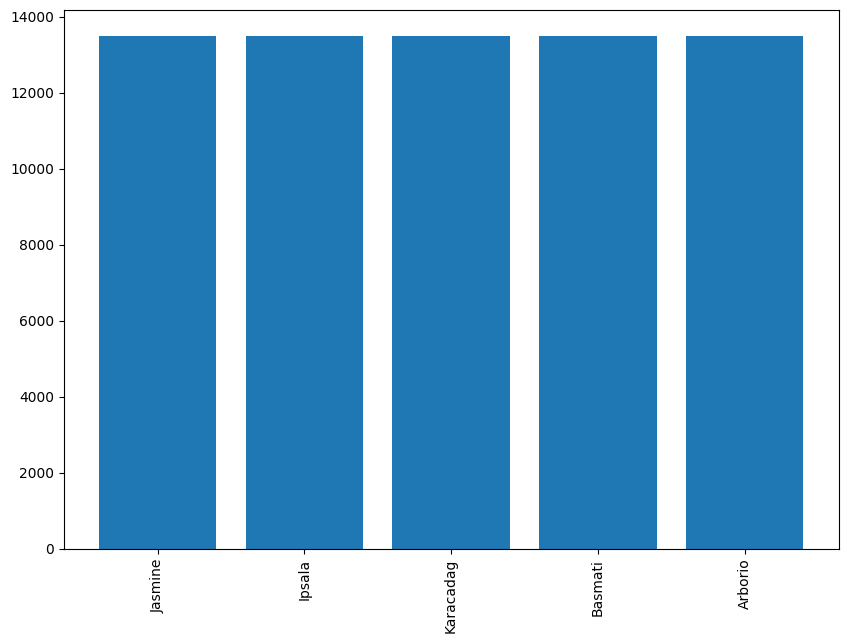

In [103]:
# Plotting the number of images in each class
plt.figure(figsize=(10,7))
plt.bar(classId_counts.index , classId_counts.sort_values())
plt.xticks(rotation='vertical')
plt.show()

In [104]:
print('The ratio between maximum counts of images to minimum counts:')
print(round(classId_counts.max() / classId_counts.min()))

The ratio between maximum counts of images to minimum counts:
1


In [105]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    labels='inferred',
    label_mode='categorical',
    subset="both",
    seed=101,
    shuffle=True,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)

Found 67500 files belonging to 5 classes.
Using 54000 files for training.
Using 13500 files for validation.


In [106]:
class_names = train_ds.class_names
print(class_names)


['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


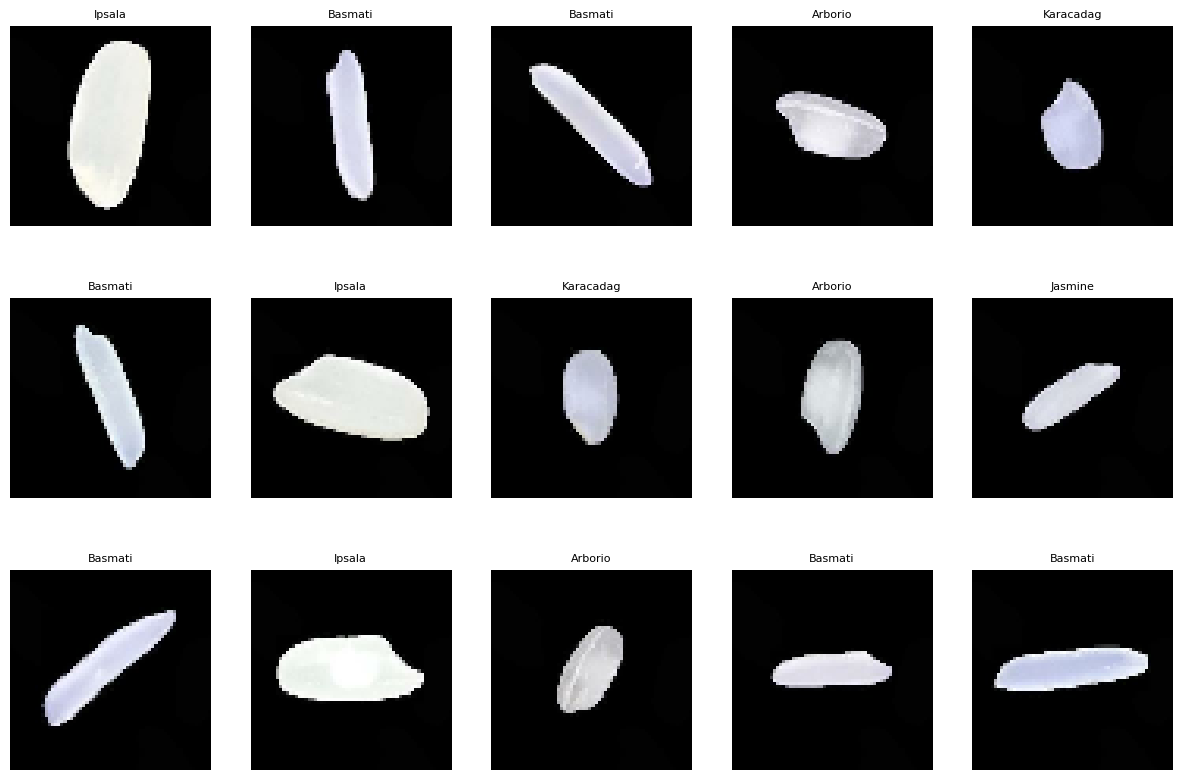

In [107]:
#Visualize the data
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
  for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(labels[i])],fontsize = 8)
    plt.axis("off")

In [108]:
#shapes
for image_batch, labels_batch in train_ds:
  print('Shape of images: ', image_batch.shape)
  print('Shape of batches:' ,labels_batch.shape)
  break

Shape of images:  (32, 64, 64, 3)
Shape of batches: (32, 5)


In [109]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


### Building the model

first model uses no image augmentation

and second model uses image augmentation

In [110]:
#function for plottimg losses and validations
def plot_loss_accuracy(history):
  """
    Plots the training and validation accuracy, and training and validation loss.

    Args:
        history: The history object returned by the `model.fit()` function.
    """
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(EPOCHS)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [114]:
NUMBER_OF_CLASSES = len(class_names)
EPOCHS=20

In [298]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, channels)),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.2),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.2),

  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.3),
  layers.Dense(NUMBER_OF_CLASSES, activation='softmax'),
])

In [299]:
initial_learning_rate = 0.001

In [300]:
# Learning Rate Scheduling
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [301]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [302]:
model.summary()


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_18 (Rescaling)    (None, 64, 64, 3)         0         
                                                                 
 conv2d_131 (Conv2D)         (None, 64, 64, 16)        448       
                                                                 
 conv2d_132 (Conv2D)         (None, 64, 64, 16)        2320      
                                                                 
 conv2d_133 (Conv2D)         (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d_49 (MaxPooli  (None, 32, 32, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_21 (Dropout)        (None, 32, 32, 16)        0         
                                                     

In [303]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[lr_callback]
)

Epoch 1/20
1688/1688 [==============================] - 28s 14ms/step - loss: 0.2220 - accuracy: 0.9173 - val_loss: 0.1087 - val_accuracy: 0.9627 - lr: 0.0010
Epoch 2/20
1688/1688 [==============================] - 23s 13ms/step - loss: 0.1188 - accuracy: 0.9609 - val_loss: 0.0907 - val_accuracy: 0.9687 - lr: 0.0010
Epoch 3/20
1688/1688 [==============================] - 23s 14ms/step - loss: 0.1021 - accuracy: 0.9666 - val_loss: 0.0658 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 4/20
1688/1688 [==============================] - 24s 14ms/step - loss: 0.0621 - accuracy: 0.9808 - val_loss: 0.0423 - val_accuracy: 0.9863 - lr: 0.0010
Epoch 5/20
1688/1688 [==============================] - 24s 14ms/step - loss: 0.0481 - accuracy: 0.9851 - val_loss: 0.0269 - val_accuracy: 0.9922 - lr: 0.0010
Epoch 6/20
1688/1688 [==============================] - 24s 14ms/step - loss: 0.0373 - accuracy: 0.9885 - val_loss: 0.0303 - val_accuracy: 0.9913 - lr: 0.0010
Epoch 7/20
1688/1688 [========================

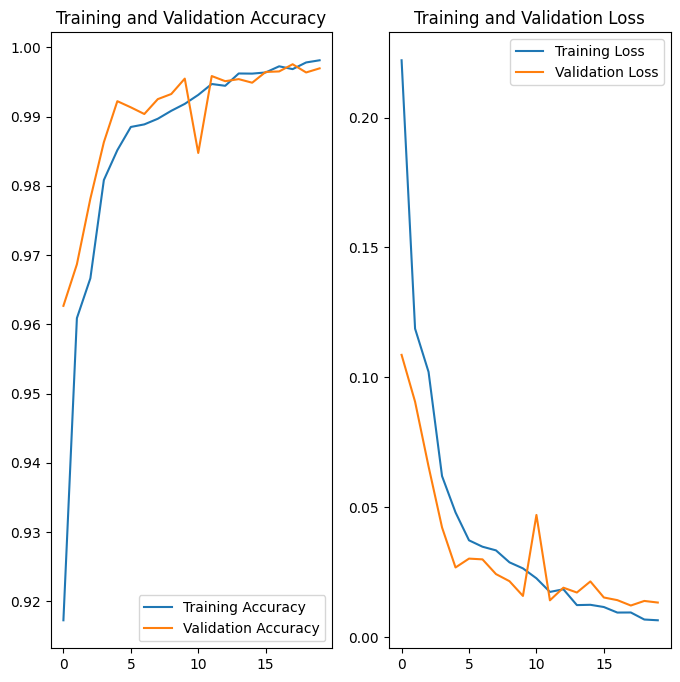

In [304]:
plot_loss_accuracy(history)

In [305]:
model.evaluate(val_ds)

422/422 [==============================] - 2s 4ms/step - loss: 0.0134 - accuracy: 0.9970


[0.013412754982709885, 0.9969629645347595]

In [306]:
def get_misclassified_images(model, val_ds):
    """
    Retrieves the misclassified images and labels from a given model and validation dataset.

    Parameters:
    model (tf.keras.Model): The trained model.
    val_ds (tf.data.Dataset): The validation dataset.

    Returns:
    misclassified_images (numpy.ndarray): Array of misclassified images.
    misclassified_labels (numpy.ndarray): Array of misclassified labels.
    predictions (numpy.ndarray): Array of predicted labels.
    labels (numpy.ndarray): Array of true labels.
    """

    misclassified_images = []
    misclassified_labels = []
    predictions = np.array([])
    labels = np.array([])

    for x, y in val_ds:
        predicted = np.argmax(model.predict(x), axis=-1)
        lbl = np.argmax(y.numpy(), axis=-1)

        labels = np.concatenate([labels, lbl])
        predictions = np.concatenate([predictions, predicted])

        misclassified = lbl != predicted
        misclassified_images.extend(x[misclassified])
        misclassified_labels.extend(predicted[misclassified])

    misclassified_images = np.array(misclassified_images)
    misclassified_labels = np.array(misclassified_labels)

    return misclassified_images, misclassified_labels, predictions, labels


def plot_confusion_matrix(labels, predictions):
    """
    Plots the confusion matrix based on the provided labels and predictions.

    Parameters:
    labels (array-like): True labels.
    predictions (array-like): Predicted labels.
    """

    # Create the confusion matrix display from the labels and predictions
    disp = ConfusionMatrixDisplay.from_predictions(labels, predictions, xticks_rotation=90, cmap='Blues', values_format='d')
    fig = disp.figure_

    # Set the figure width and height
    fig.set_figwidth(10)
    fig.set_figheight(10)

    # Set the font size for x and y tick labels
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    # Set the colorbar font size
    cbar = disp.im_.colorbar
    cbar.ax.tick_params(labelsize=8)

    # Set the title and labels
    plt.title('Confusion Matrix', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=10)
    plt.ylabel('True Label', fontsize=10)

    # Show the plot
    plt.tight_layout()
    plt.show()

def display_random_misclassified_images(misclassified_images, misclassified_labels, class_names, num_images=15):
    """
    Displays a random selection of misclassified images with their predicted labels.

    Parameters:
    misclassified_images (numpy.ndarray): Array of misclassified images.
    misclassified_labels (numpy.ndarray): Array of misclassified labels.
    classes (list): List of class labels.
    num_images (int): Number of images to display. Default is 15.
    """


    random_indexes = np.random.choice(len(misclassified_images), size=num_images, replace=False)
    misclassified_images = misclassified_images[random_indexes]
    misclassified_labels = misclassified_labels[random_indexes]

    fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))

    for i, ax in enumerate(axes.flat):
        ax.imshow(misclassified_images[i].astype('uint8'))
        predicted_label = class_names[int(misclassified_labels[i])]  # Use np.argmax instead of tf.argmax
        actual = class_names[int(labels[i])]
        ax.set_title(f"Predicted: {predicted_label}\nActual: {actual}", fontsize=8)
        ax.axis('off')

    plt.tight_layout()
    plt.show()




In [307]:
misclassified_images, misclassified_labels , predictions, labels = get_misclassified_images(model, val_ds)

1/1 [==============================] - 0s 197ms/step


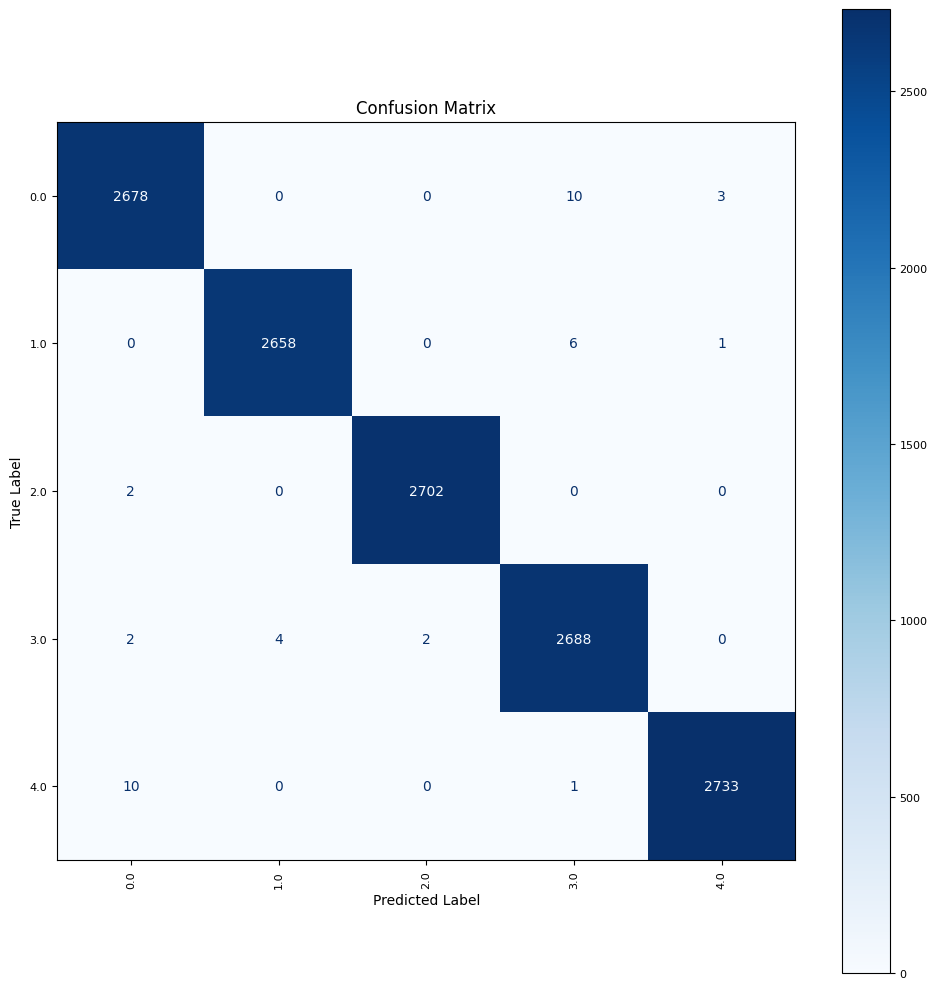

In [308]:
plot_confusion_matrix(labels, predictions)

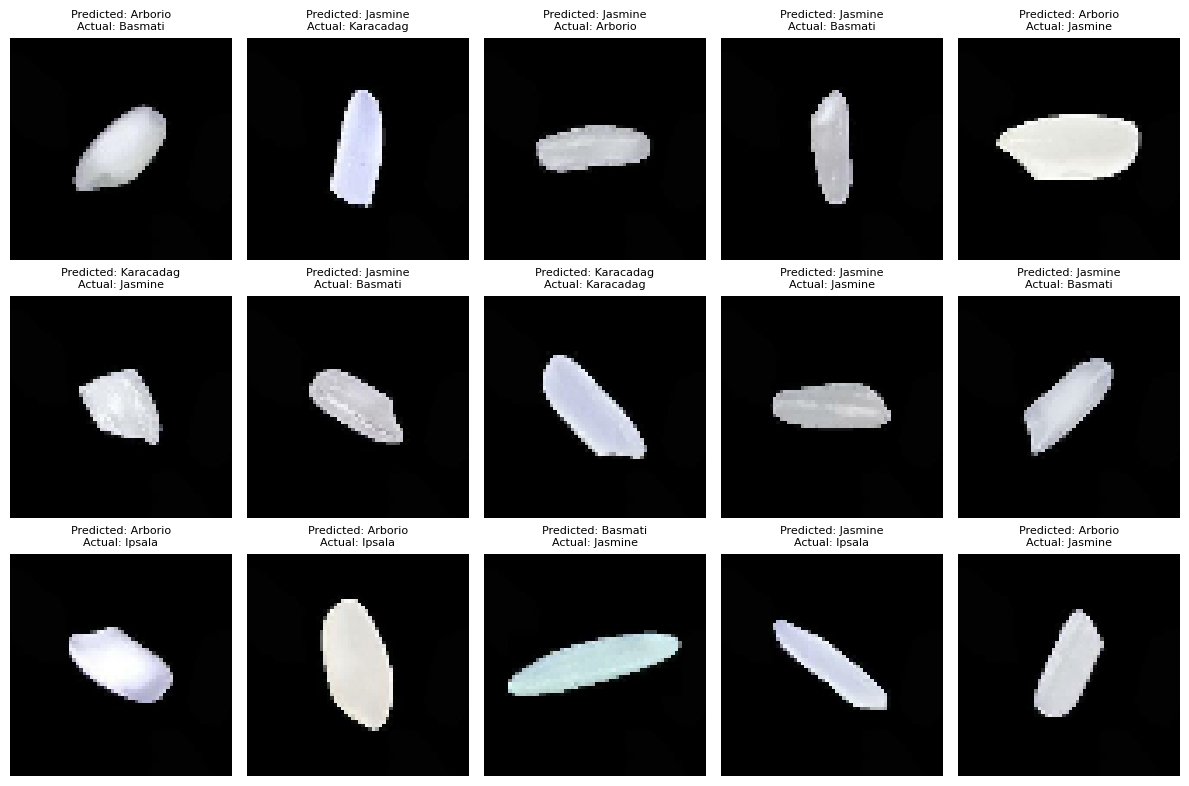

In [309]:
#sample missclassified images
display_random_misclassified_images(misclassified_images, misclassified_labels, class_names)




Now we add augmentation to image

In [253]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(IMG_HEIGHT,
                                  IMG_WIDTH,
                                  3)),
    layers.RandomRotation(0.15),
    layers.RandomTranslation(.15, .15),
    layers.RandomZoom(0.15),
    layers.RandomContrast(.1),
    layers.RandomBrightness(.1),
  ]
)

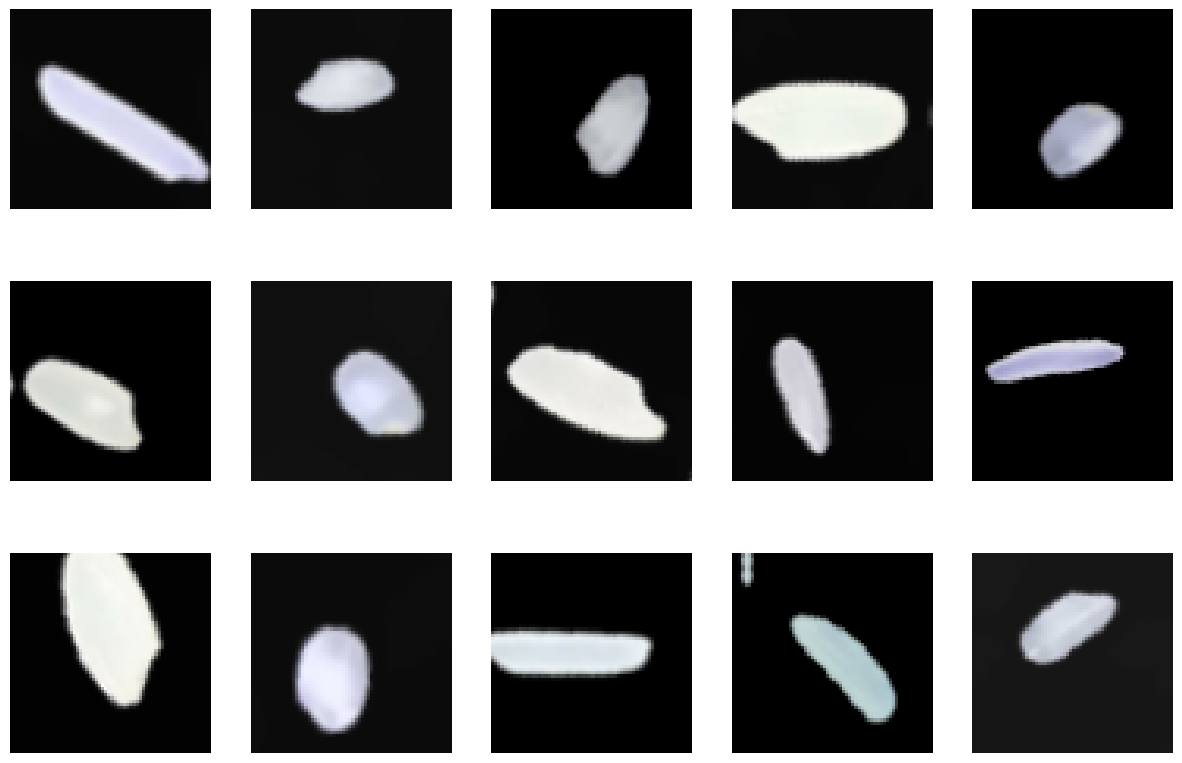

In [254]:
#adding augmentation to trianing images
plt.figure(figsize=(15, 10))
for images, _ in train_ds.take(1):
  for i in range(15):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.axis("off")

In [284]:
model_aug = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, channels)),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.3),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.3),
  layers.Dense(NUMBER_OF_CLASSES, activation='softmax'),
])

In [288]:
model_aug.summary()


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_11 (Sequential)  (None, 64, 64, 3)         0         
                                                                 
 rescaling_16 (Rescaling)    (None, 64, 64, 3)         0         
                                                                 
 conv2d_113 (Conv2D)         (None, 64, 64, 16)        448       
                                                                 
 conv2d_114 (Conv2D)         (None, 64, 64, 16)        2320      
                                                                 
 conv2d_115 (Conv2D)         (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 32, 32, 16)        0         
 ng2D)                                                           
                                                     

In [289]:
history_aug= model_aug.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[lr_callback]
)

Epoch 1/20
1688/1688 [==============================] - 33s 17ms/step - loss: 0.4969 - accuracy: 0.7951 - val_loss: 0.5037 - val_accuracy: 0.7920 - lr: 0.0010
Epoch 2/20
1688/1688 [==============================] - 28s 16ms/step - loss: 0.1550 - accuracy: 0.9477 - val_loss: 0.1022 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 3/20
1688/1688 [==============================] - 28s 17ms/step - loss: 0.1022 - accuracy: 0.9662 - val_loss: 0.0795 - val_accuracy: 0.9714 - lr: 0.0010
Epoch 4/20
1688/1688 [==============================] - 28s 17ms/step - loss: 0.0838 - accuracy: 0.9734 - val_loss: 0.0869 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 5/20
1688/1688 [==============================] - 28s 17ms/step - loss: 0.0662 - accuracy: 0.9799 - val_loss: 0.0668 - val_accuracy: 0.9755 - lr: 0.0010
Epoch 6/20
1688/1688 [==============================] - 28s 17ms/step - loss: 0.0769 - accuracy: 0.9759 - val_loss: 1.0059 - val_accuracy: 0.6842 - lr: 0.0010
Epoch 7/20
1688/1688 [========================

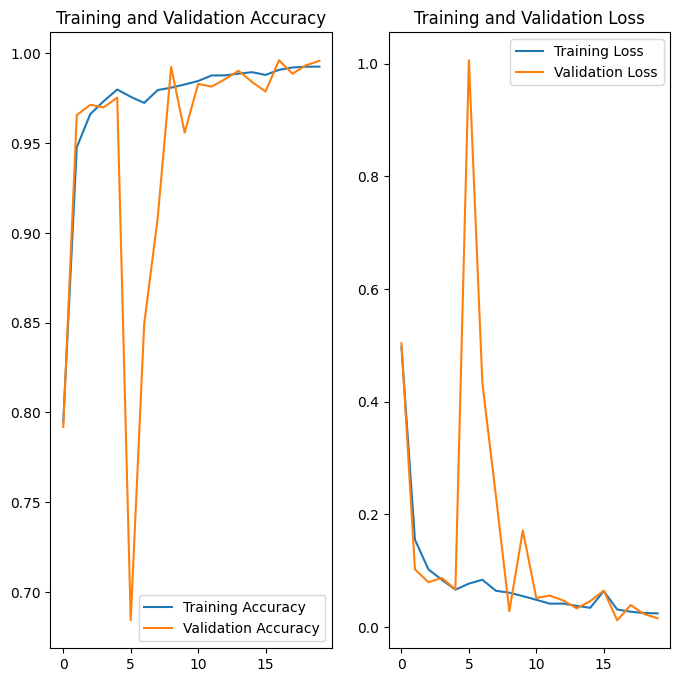

In [290]:
plot_loss_accuracy(history_aug)

In [310]:
model_aug.evaluate(val_ds)

422/422 [==============================] - 2s 5ms/step - loss: 0.0153 - accuracy: 0.9959


[0.015329549089074135, 0.9959259033203125]

In [311]:
misclassified_images_aug, misclassified_labels_aug , predictions_aug, labels_aug = get_misclassified_images(model_aug, val_ds)

1/1 [==============================] - 0s 129ms/step


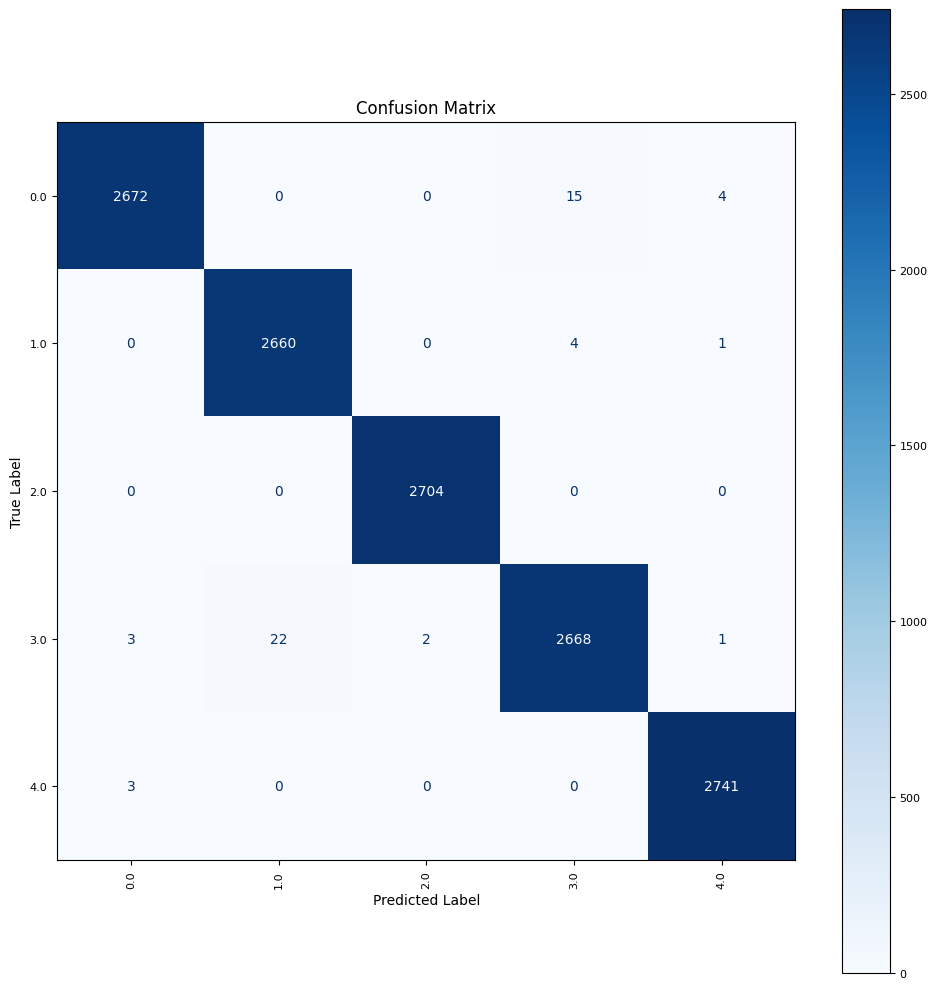

In [312]:
plot_confusion_matrix(labels_aug, predictions_aug)

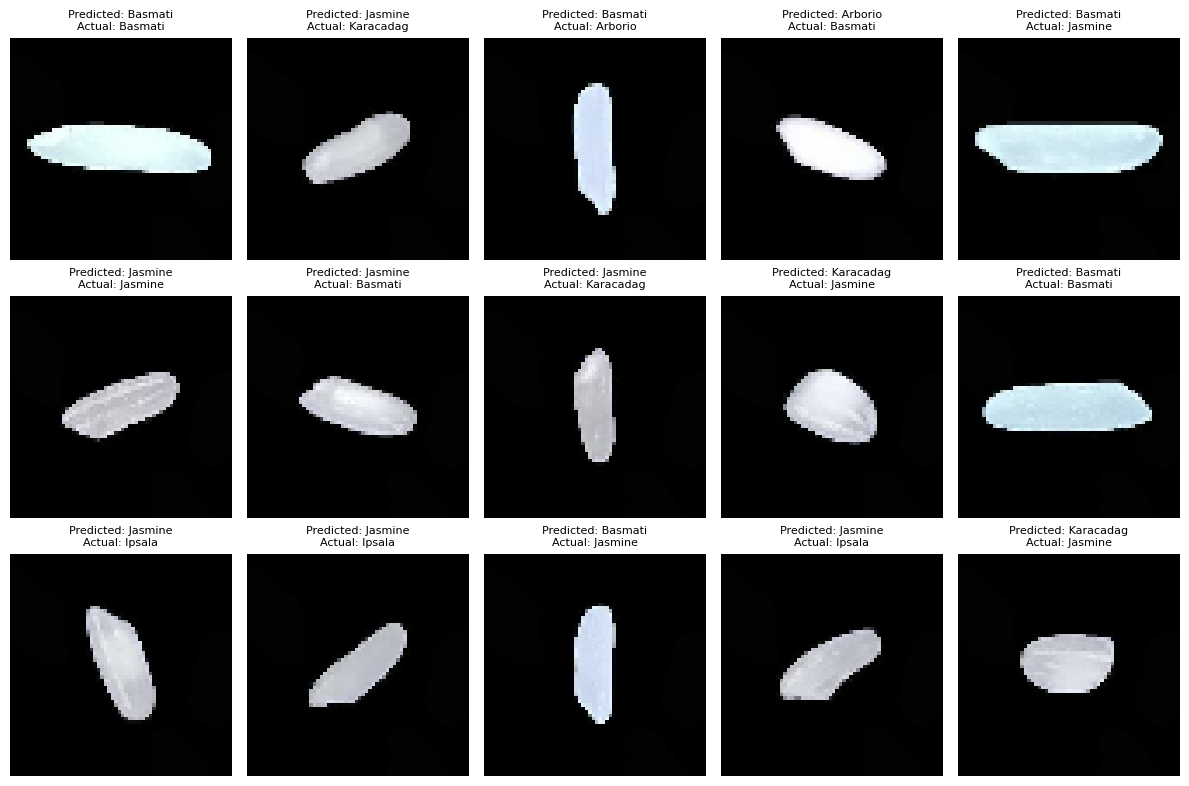

In [313]:
#missclassified  on augmented image
display_random_misclassified_images(misclassified_images_aug, misclassified_labels_aug, class_names)


### Predict on new data

In [212]:
def get_test_images(model, labels, class_names, image_paths, size = 1):
    predictions = []
    true_labels = []
    images = []
    random_indices = np.random.randint(0, len(image_paths), size)
    for i, img in list(zip(random_indices , image_paths[random_indices])):
      image = tf.keras.utils.load_img(
        img , target_size=(IMG_HEIGHT, IMG_WIDTH))
      image = tf.keras.utils.img_to_array(image)
      image = tf.expand_dims(image, 0) # Create a batch
      images.append(image)
      pred = model.predict(image)
      score = tf.nn.softmax(pred)
      predicted_class = class_names[np.argmax(score)]
      predicted_prob = 100 * np.max(score)
      predictions.append(predicted_class)
      true_labels.append(labels[i])

    return predictions, true_labels, images


def display_random_test_images(images, true_labels, predictions, num_images=15):
    fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 8))

    for i, ax in enumerate(axes.flat):
        if int(predictions) != int(true_labels):
          col = 'r'
        else:
          col = 'g'
        ax.imshow(images[i].astype('uint8'))
        # ax.set_title(f"Predicted: {classes[i]}", fontsize=8)
        ax.xlabel('Actual={} || Pred={}'.format(classes[int(labels[i])],
                                                 classes[int(predicted_class)]),
                   color = col , fontsize=8)
        # plt.imshow(pic)
        # ax.axis('off')

    plt.tight_layout()
    plt.show()


In [226]:

def plot_images(predictions, true_labels, images, class_names, image_width=800, image_height=600):
    num_images = len(images)
    num_columns = 5

    num_rows = (num_images + num_columns - 1) // num_columns

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 10))

    for i, (pred, true_label, image) in enumerate(zip(predictions, true_labels, images)):
        row = i // num_columns
        col = i % num_columns

        axes[row, col].imshow(image[0].numpy().astype('uint8'))
        pred_label = class_names[pred] if isinstance(pred, int) else pred
        true_label = class_names[true_label] if isinstance(true_label, int) else true_label
        title = f'Prediction: {pred_label}\nTrue Label: {true_label}'

        if pred != true_label:
            axes[row, col].title.set_color('red')
        else:
            axes[row, col].title.set_color('green')

        axes[row, col].set_title(title, fontsize=8)
        axes[row, col].axis('off')

    # Remove any empty subplots
    if num_images < num_rows * num_columns:
        for j in range(num_images, num_rows * num_columns):
            row = j // num_columns
            col = j % num_columns
            fig.delaxes(axes[row, col])

    plt.tight_layout()
    plt.show()

In [207]:
df_test.head()

,image_path,label
0,Single_Test_Folder/Jasmine_Jasmine (7649).jpg,Jasmine
1,Single_Test_Folder/Ipsala_Ipsala (8049).jpg,Ipsala
2,Single_Test_Folder/Karacadag_Karacadag (6659).jpg,Karacadag
3,Single_Test_Folder/Arborio_Arborio (2029).jpg,Arborio
4,Single_Test_Folder/Ipsala_Ipsala (5418).jpg,Ipsala


In [314]:
labels = df_test['label'].values
image_paths = df_test['image_path'].values

In [315]:
predictions , true_labels, images = get_test_images(model, labels, class_names, image_paths, size=20)

1/1 [==============================] - 0s 24ms/step


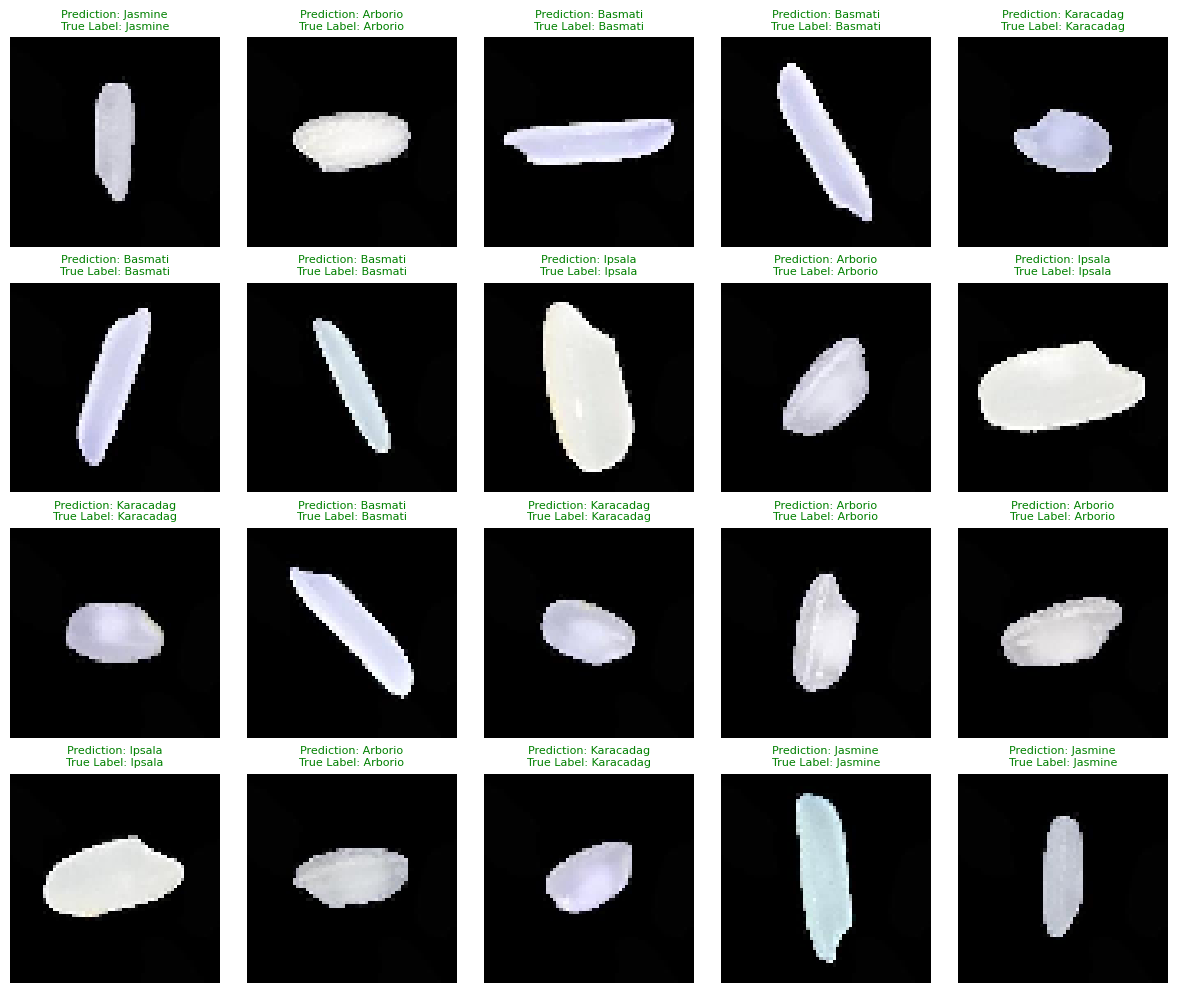

In [316]:
plot_images(predictions, true_labels, images, class_names)


